# Импортируем библиотеки
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
from scipy import stats
%matplotlib inline

In [2]:
# Подключаемся к базе данных
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220620'
}

In [81]:
# Создаем запрос
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-05-24' and '2022-05-30'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

# Загружаем данные из clickhouse
df = ph.read_clickhouse(q, connection=connection)

In [82]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


1) Для начала посмотрим на наше распределение по группам с помощью гистограммы:

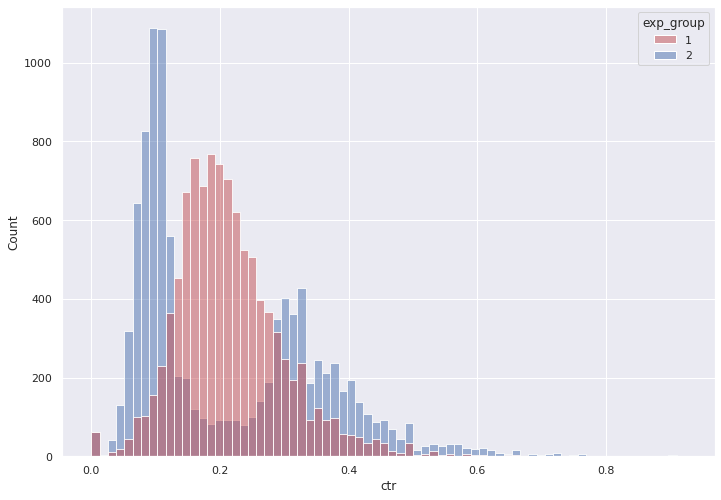

In [84]:
# Отрегулируем размер графиков в seaborn 
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Зададим параметры гистограммы, показывающей распределение CTR
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

На данном этапе можно сказать, что в группе №1 распределение CTR "на глаз" выглядит нормальным. В то же время распределение в группе №2 - "двугорбое" или двумодальное. Следовательно, t-тест в данном случае не стоит применять, так как он покажет искаженный результат. Убедимся в этом.

In [86]:
# Проведем t-test для групп 1 и 2 по CTR
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Вывод по пунтку 1: поскольку полученные значения p-value намного > 0.05, мы не можем отклонить нулевую гипотезу о равенстве средних. Однако в силу ненормальности распределения не стоит полагаться на t-test. 
Применим другие методы.

2) Попробуем сравнить полученный результат с тестом Манна-Уитни:

In [89]:
# Выведем результаты теста Манна-Уитни
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                         df[df.exp_group == 2].ctr))

# Рассчитаем, в каком проценте случаев CTR в группе 1 больше CTR в группе 2
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев CTR в одной группе больше CTR в другой')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)
В 56.43 % случаев CTR в одной группе больше CTR в другой


Вывод по пункту 2: Тест Манна-Уитни подтверждает результат t-теста. Различия между двумя группами довольно существенны. Тем не менее полученный результат не намного больше 50%. Следовательно, за получением более точной информации необходимо обратиться к другим методам статистического анализа.

3) Пуассоновский бутстреп:

In [40]:
# Вводим функцию Пуассоновского бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [42]:
# Подготовим переменные
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

# запускаем бутстреп
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

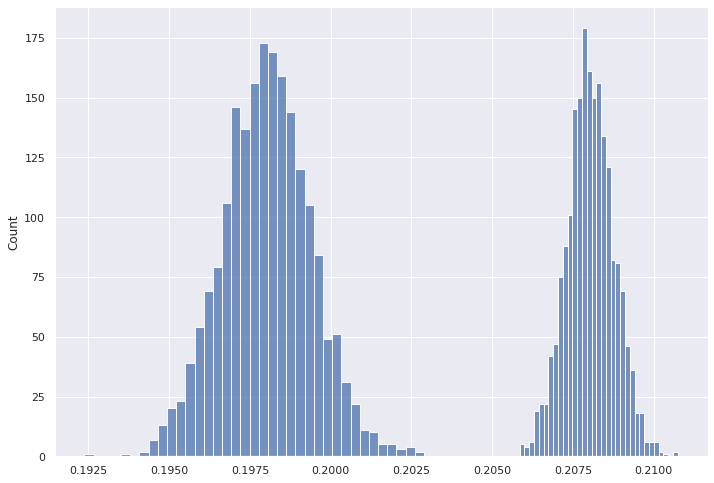

In [43]:
# Визуализирем бутстреп при помощи гистограммы
sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

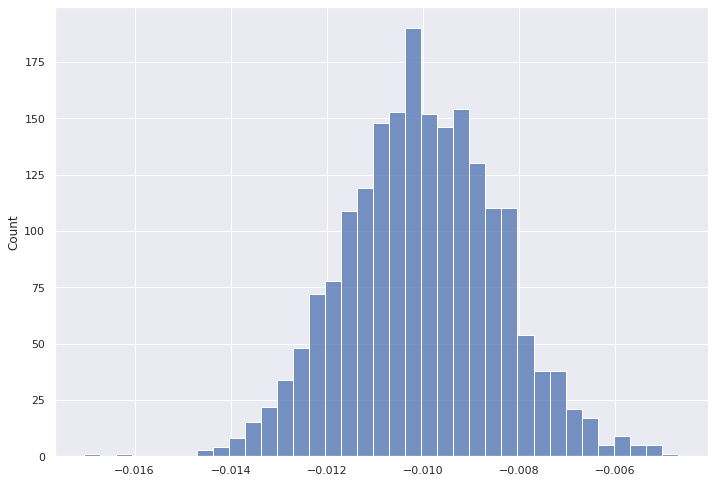

In [48]:
# Построим разницу между глобальными CTR
sns.histplot(ctr2 - ctr1)

Вывод по пункту 3: На гистограмме видно, что распределение CTR первой группы не пересекается с распределением CTR второй группы. Более того, график разницы между глобальными CTR не включает 0. Это подтверждает сильное различие между двумя группами. Стоит также отметить, что разница глобальных CTR является отрицательной. А значит, CTR в контрольной группе выше, чем в экспериментальной. Следовательно, внедрение нового алгоритма рекомендаций приведет не к увеличению, а, наоборот, к падению CTR.

4) Бакетное преобразование:

In [70]:
# Создадим новый SQLзапрос
q2 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-05-24' and '2022-05-30'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

# Загружаем данные из clickhouse
df_bucket = ph.read_clickhouse(q2, connection=connection)

In [71]:
df_bucket

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314
...,...,...,...,...
95,2,47,0.195880,0.426230
96,1,48,0.212787,0.318182
97,2,48,0.194502,0.409091
98,1,49,0.203169,0.325581


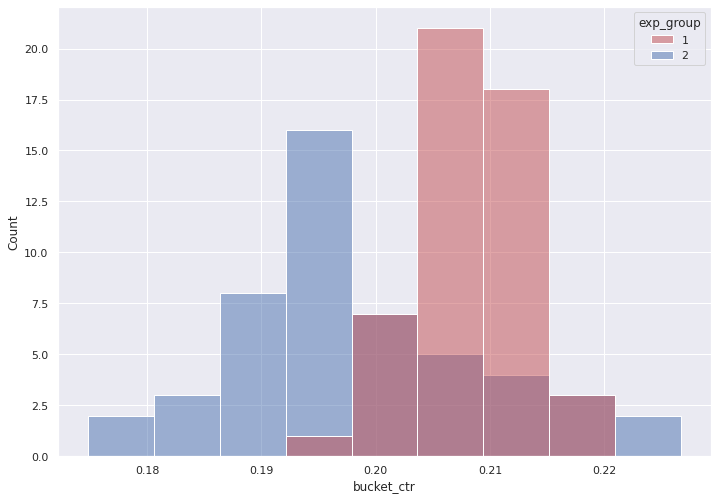

In [72]:
# Построим гистограмму
# Отрегулируем размер графиков в seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Зададим параметры гистограммы
groups = sns.histplot(data = df_bucket, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [73]:
# T-тест поверх бакетного преобразования
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [74]:
# Тест Манна-Уитни поверх бакетного преобразования
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Проведенный бакетный анализ и статистические тесты поверх него также подтверждают наличие статистически значимых различий между группами 1 и 2.

Итоговая рекомендация: Анализ показал, что раскатывание нового алгоритма на всех пользователей может привести к снижению CTR. Необходимо разработать новый алкоритм, либо попытаться улучшить текущий.